Final Project
============
I will implement the classifier with U-Net using ADE20K dataset.

# 1. Preparation

Imports library and assign GPU.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import warnings
warnings.filterwarnings("ignore")

from dataloader import SegmentationData
from myNN import SegmentationNN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

print(device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


# 1. Preparation

Load training and validation dataset.

In [18]:
exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(exercises_path, 'Final_Project', 'ADE20Kdataset')
print(data_root)

train_data = SegmentationData(
    image_paths_file=f'{data_root}/images/training.txt')
val_data = SegmentationData(
    image_paths_file=f'{data_root}/images/validation.txt')


/home/jamesqian/Documents/DeepVision/Final_Project/ADE20Kdataset


Color the masks.

In [36]:
def rgb(imag):
    imag = np.array([imag+1, ((imag+1)*0.8).astype(int),((imag+1)*0.8).astype(int)])
    imag = imag.transpose(1, 2, 0)
    return imag

Show the few dataset.

Train size: 20208
Validation size: 2000
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


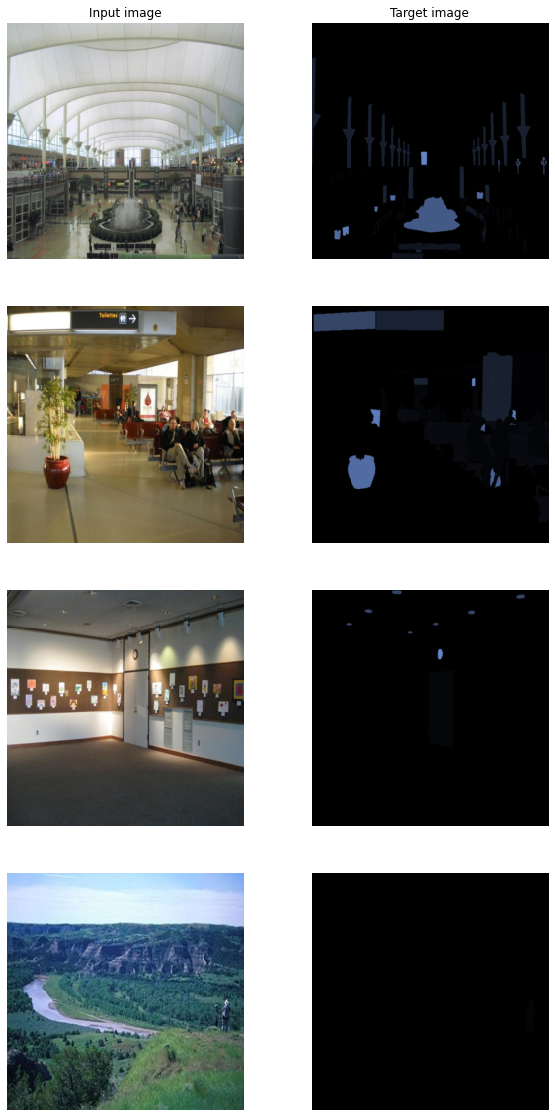

In [20]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target, h, w) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1, 2, 0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")

    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    target = target.numpy()
    plt.imshow(rgb(target))
    torch.set_printoptions(profile="full")
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()


Show image shape.

In [21]:
for i, (img, target, h, w) in enumerate(train_data):
    print('Image shape:', np.shape(img))
    print('Mask shape:', np.shape(target))
    print('Image size:', h, 'x', w)
    break


Image shape: torch.Size([3, 240, 240])
Mask shape: torch.Size([240, 240])
Image size: 512 x 683


Define the evaluate function.

In [22]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets, h, w in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = targets >= 0
        test_scores.append(np.nanmean(
            (preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.nanmean(test_scores)


# 2. Training

Set hyperparameter.

In [23]:
hparams = {
    'lr': 0.000085,
    'epochs': 100,
    'm': 0.7
}


Start tarning.

In [8]:
model = SegmentationNN(hparams=hparams)
model = model.to(device)
model.load_state_dict(torch.load("weight.pt"))
model.train()
torch.cuda.empty_cache()

batch = 16

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
optimizer = torch.optim.SGD(
    model.parameters(), lr=hparams['lr'], momentum=hparams['m'])

for epoch in range(0, hparams['epochs']):
    current_loss = 0.0
    nan = 0
    count = 0
    for i, (img, target, h, w) in enumerate(train_data):

        tmp_X = img.unsqueeze(0)
        tmp_y = target.unsqueeze(0)

        if((i+1) % batch-1 == 0 or i == 0):
            global X, y
            X = tmp_X
            y = tmp_y
        else:
            X = torch.cat((X, tmp_X))
            y = torch.cat((y, tmp_y))

        if (i+1) % batch == 0 and i != 0:

            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model(X)

            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            if not np.isnan(loss.item()):
                current_loss += loss.item()
                count += 1
                if count % 100 == 0:
                    print("[Epoch %d_%d] loss: %.3f" %
                          (epoch+1, i+1, current_loss/count))

            _, preds = torch.max(y_pred, 1)

    current_loss /= count
    print("[Epoch %d] loss: %.3f" % (epoch+1, current_loss))
    if((epoch+1) % 2 == 0):
        test_loader = torch.utils.data.DataLoader(
            val_data, batch_size=1, shuffle=False, num_workers=0)
        acc = evaluate_model(model, test_loader)
        print('acc:', acc)

    torch.save(model.state_dict(), "weight/epoch" +str(epoch+1) + ".pt")
    print('Module weights saved.')


print('FINISH.')

[Epoch 1_1600] loss: 3.532
[Epoch 1_3200] loss: 3.555
[Epoch 1_4800] loss: 3.419
[Epoch 1_6400] loss: 3.458
[Epoch 1_8032] loss: 3.431
[Epoch 1_9664] loss: 3.428
[Epoch 1_11264] loss: 3.450
[Epoch 1_12912] loss: 3.453
[Epoch 1_14512] loss: 3.474
[Epoch 1_16112] loss: 3.477
[Epoch 1_17712] loss: 3.449
[Epoch 1_19312] loss: 3.412
[Epoch 1] loss: 3.419
Module weights saved.
[Epoch 2_1600] loss: 3.528
[Epoch 2_3200] loss: 3.553
[Epoch 2_4800] loss: 3.417
[Epoch 2_6400] loss: 3.456
[Epoch 2_8032] loss: 3.430
[Epoch 2_9664] loss: 3.427
[Epoch 2_11264] loss: 3.449
[Epoch 2_12912] loss: 3.452
[Epoch 2_14512] loss: 3.473
[Epoch 2_16112] loss: 3.476
[Epoch 2_17712] loss: 3.448
[Epoch 2_19312] loss: 3.411
[Epoch 2] loss: 3.418
acc: 0.17065389551543525
Module weights saved.
[Epoch 3_1600] loss: 3.528
[Epoch 3_3200] loss: 3.553
[Epoch 3_4800] loss: 3.417
[Epoch 3_6400] loss: 3.456
[Epoch 3_8032] loss: 3.429
[Epoch 3_9664] loss: 3.427
[Epoch 3_11264] loss: 3.449
[Epoch 3_12912] loss: 3.452
[Epoch 3_

# 3. Validation

Evaluate the model with mIOU.

In [9]:
test_loader = torch.utils.data.DataLoader(
    val_data, batch_size=1, shuffle=False, num_workers=0)
evaluate_model(model, test_loader)

0.17066156745242295

Show the validation result.

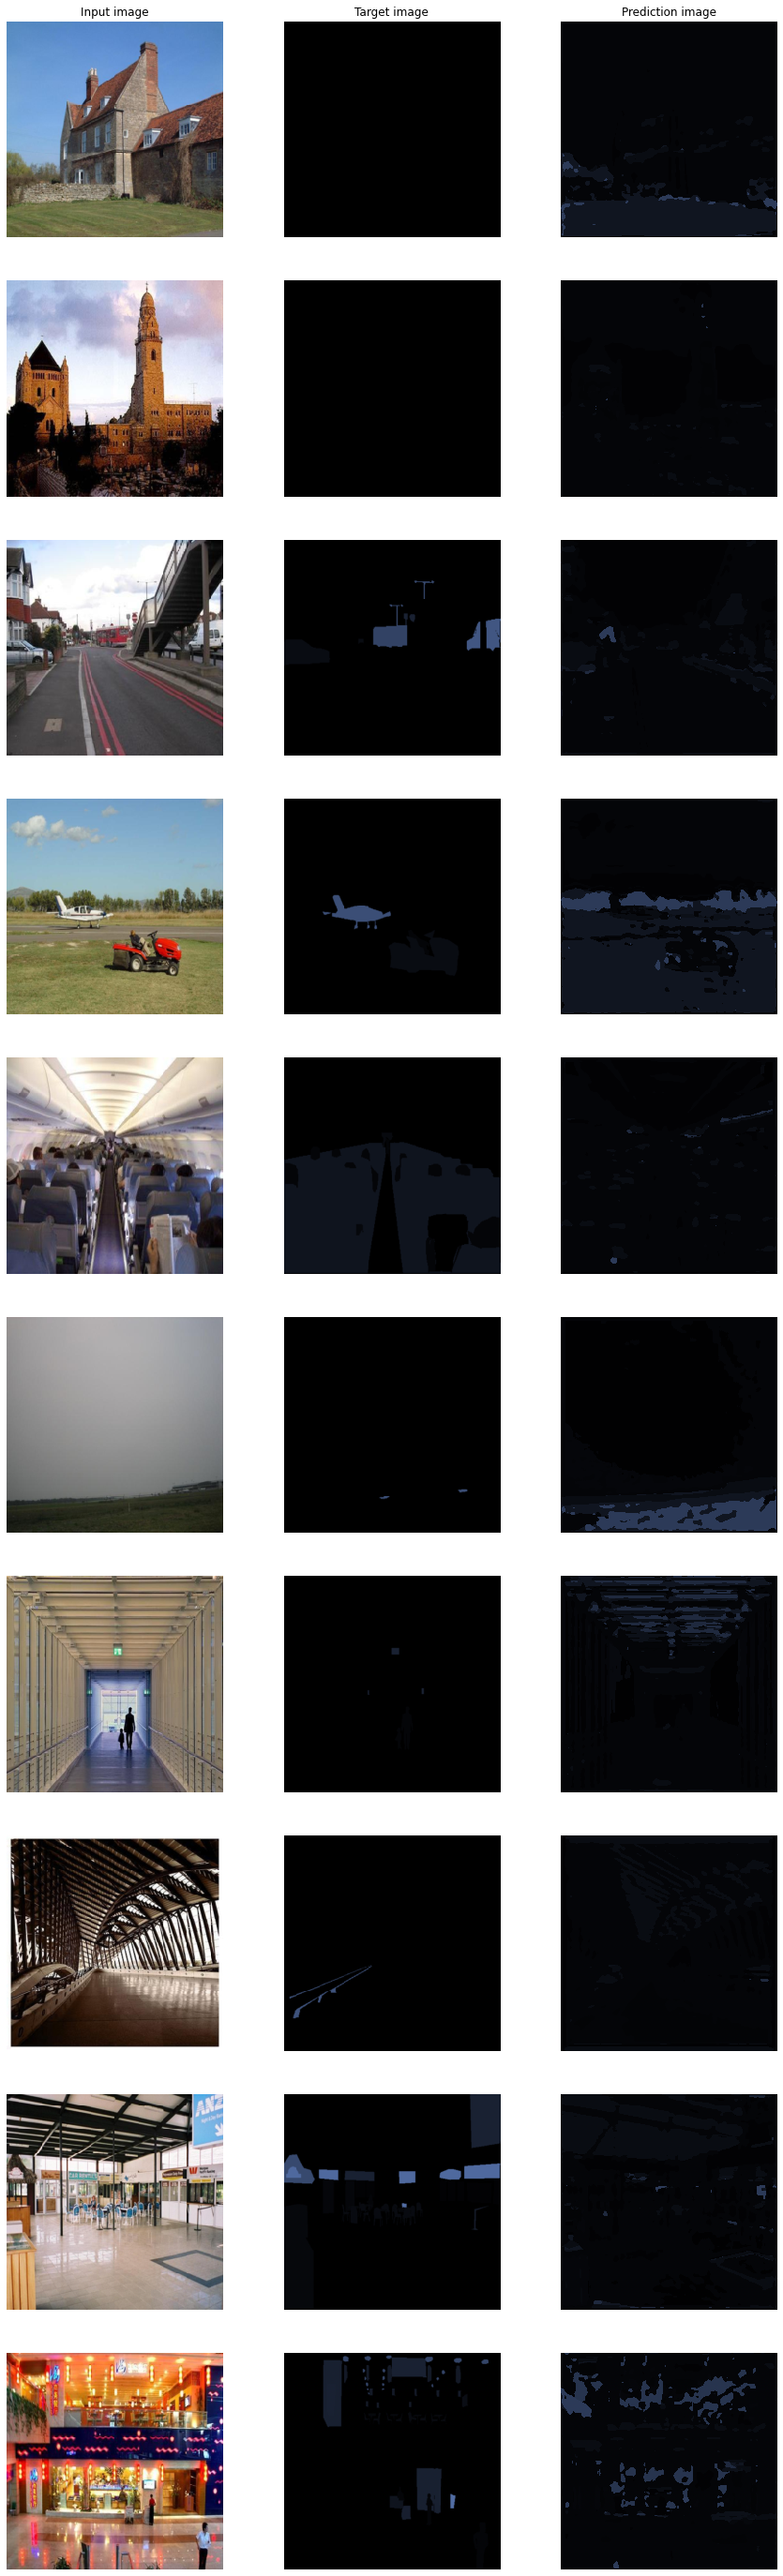

In [10]:
def visualizer(model, test_data=None):
    num_example_imgs = 10
    plt.figure(figsize=(15, 5 * num_example_imgs))
    for i, (img, target, h, w) in enumerate(test_data[:num_example_imgs]):
        inputs = img.unsqueeze(0)
        inputs = inputs.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        pred = preds[0].data.cpu()

        img, target, pred = img.numpy(), target.numpy(), pred.numpy()

        # img
        plt.subplot(num_example_imgs, 3, i * 3 + 1)
        plt.axis('off')
        plt.imshow(img.transpose(1, 2, 0))
        if i == 0:
            plt.title("Input image")

        # target
        plt.subplot(num_example_imgs, 3, i * 3 + 2)
        plt.axis('off')
        plt.imshow(rgb(target))
        if i == 0:
            plt.title("Target image")

        # pred
        plt.subplot(num_example_imgs, 3, i * 3 + 3)
        plt.axis('off')
        pred = rgb(pred)
        plt.imshow(pred)
        if i == 0:
            plt.title("Prediction image")

    plt.show()


visualizer(model, val_data)


Test with tasting dataset, and output to files.

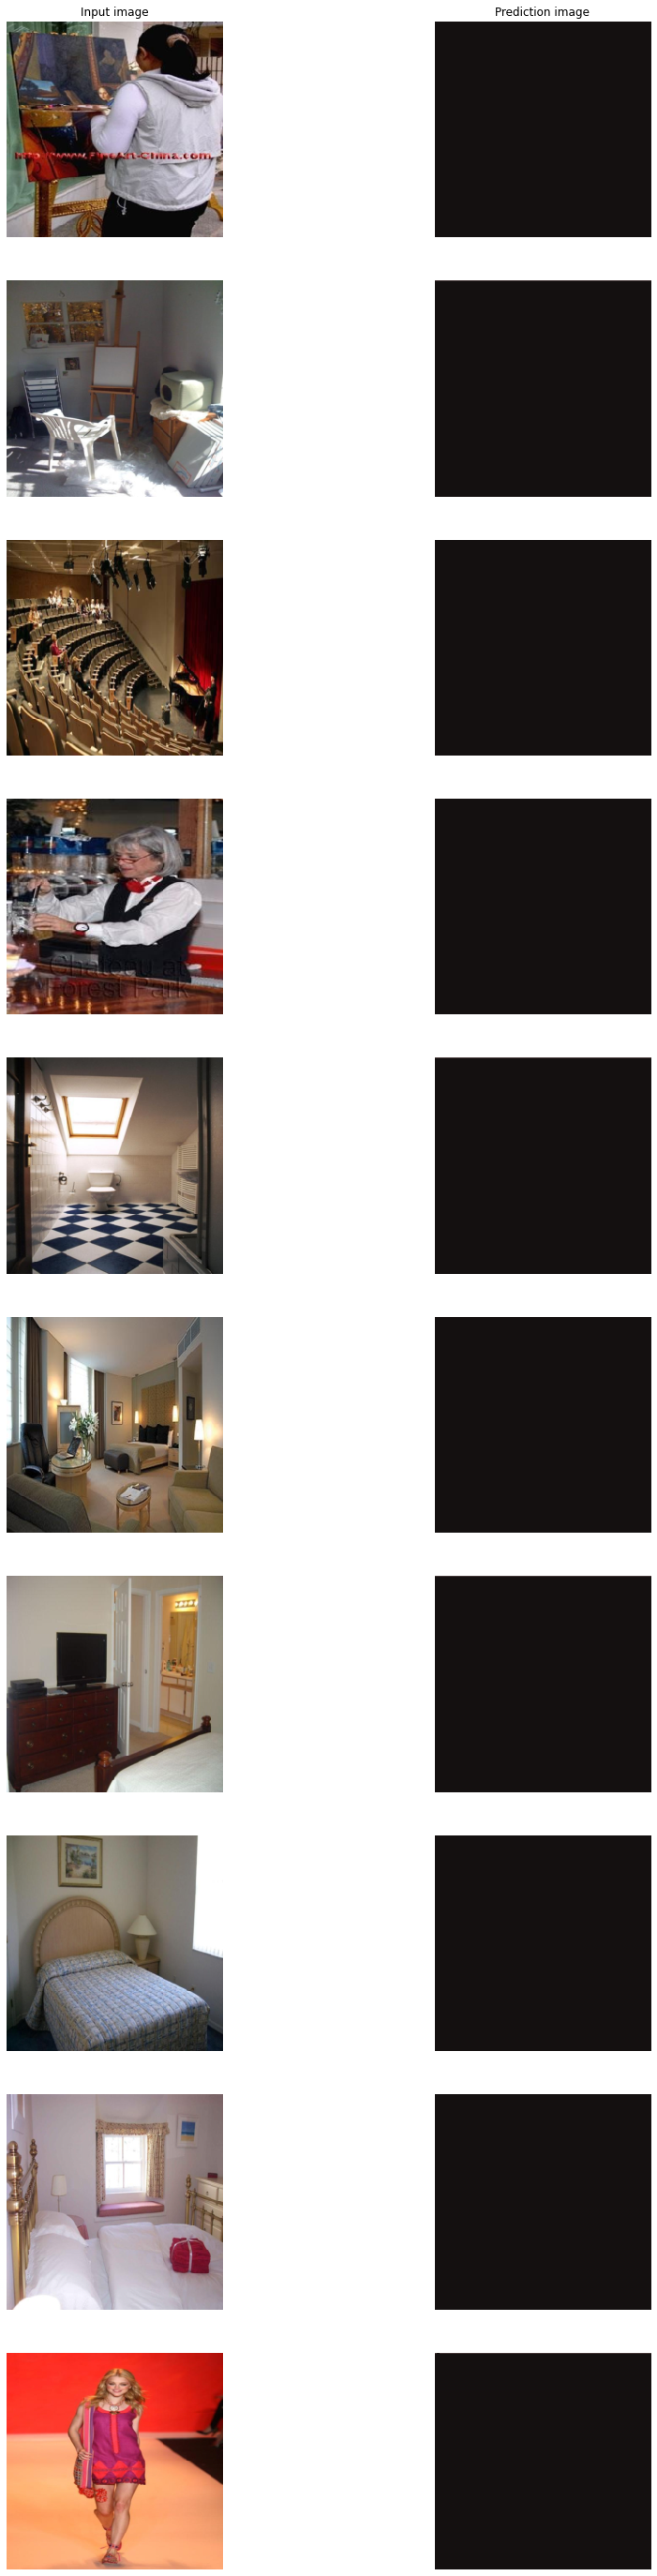

In [37]:
from PIL import Image
from torchvision import transforms

np.set_printoptions(threshold=np.inf)


def visualizer_test(model, test_data=None):
    num_example_imgs = 10
    plt.figure(figsize=(15, 5 * num_example_imgs))
    for i, (img, img_id, h, w) in enumerate(test_data[:num_example_imgs]):
        inputs = img.unsqueeze(0)
        inputs = inputs.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        pred = preds[0].data.cpu()
        img, pred = img.numpy(), pred.numpy()

        # img
        plt.subplot(num_example_imgs, 2, i * 2 + 1)
        plt.axis('off')
        plt.imshow(img.transpose(1, 2, 0))
        if i == 0:
            plt.title("Input image")

        # pred
        plt.subplot(num_example_imgs, 2, i * 2 + 2)
        plt.axis('off')
        pred = rgb(pred)
        plt.imshow(pred)
        pred = Image.fromarray(pred.astype(np.uint8))
        Resize = transforms.Resize((h, w))
        pred = Resize(pred)
        #pred.save('test/'+img_id+".png")
        if i == 0:
            plt.title("Prediction image")

    plt.show()

model = SegmentationNN(hparams=hparams)
model = model.to(device)
test_data = SegmentationData(
    image_paths_file=f'{data_root}/Testing/test.txt', test=1)
visualizer_test(model, test_data)
